# MST

In [1]:
import numpy as np
import sklearn as sk
import scipy as sp
import random
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [2]:
xs = np.array([[1, 2], [2, 3]])
xs[:, [1]]

array([[2],
       [3]])

In [230]:
def sample_dpp(K):
    n, _ = K.shape
    sample = []
    A = K.copy()
    for j in range(n):
        q = random.random()
        if q < A[j, j]:
            sample.append(j)
        else:
            A[j, j] -= 1.0
        # update
        A[(j + 1):n, j] /= A[j, j]
        A[(j + 1):n, (j + 1):n] -= A[(j + 1):n, [j]] @ A[[j], (j + 1):n] 
    return sample, A

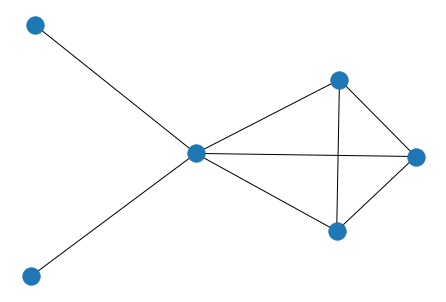

In [135]:
import networkx as nx

# generate a graph

V = list(range(6))
E = np.array([(0, 1), (0, 3), (0, 5), (1, 3), (3, 5), (2, 3), (3, 4), (1, 5)])
G = nx.Graph()
G.add_nodes_from(V)
G.add_edges_from(E)
nx.draw(G)

In [136]:
# generate star matrix
def star(E, V):
    S = np.zeros((len(E), len(V)))
    for i, e in enumerate(E):
        S[i, e[0]] = -int(e[0] < e[1])
        S[i, e[1]] = int(e[0] < e[1])
    return S

In [137]:
def kernel(S):
    Q, R, Pi = sp.linalg.qr(S, pivoting=True, mode='economic')
    #Q, R = sp.linalg.qr(S, mode='economic')
    Q = np.transpose(np.transpose(Q)[np.array(list(map(lambda x: np.linalg.norm(x), R))) > 1e-9])
    P = Q @ np.transpose(Q)
    return P

In [138]:
P = kernel(star(E, V))

[0, 1, 4, 5, 6]


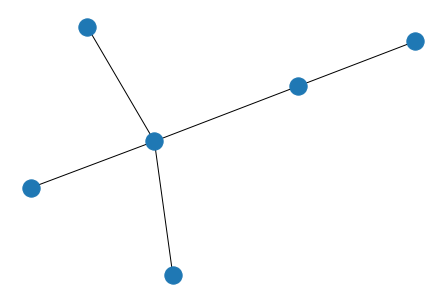

In [139]:
samples, B = sample_dpp(P)
print(samples)
edges = np.take(E, samples, 0)
G2 = nx.Graph()
G2.add_nodes_from(V)
G2.add_edges_from(edges)
nx.draw(G2)

# Grid

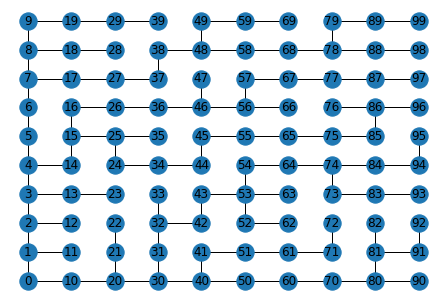

In [140]:
grid = nx.grid_graph([10, 10])
Eg = list(grid.edges)
Vg = grid.nodes
order = {k: v for (v, k) in enumerate(Vg)}
Egg=np.array([(order[u], order[v]) for u, v in Eg])
Pg = kernel(star(Egg, np.arange(0, len(Vg))))
samples, B = sample_dpp(Pg)

pos = {i: p for i, p in enumerate(Vg)}

Gg = nx.Graph()
edges = Egg[samples]
Gg.add_nodes_from(np.arange(0, len(Vg)))
Gg.add_edges_from(edges)
nx.draw(Gg, with_labels=True, pos=pos)

# Wiki

In [141]:
import math
from numpy.linalg import norm

%matplotlib inline

In [11]:
re.sub("[0123456789]", "D", "0123xasd")

'DDDDxasd'

In [162]:
import glob

dic = {}

files = glob.glob("data/wikipedia/*/*")
for fname in files[:50]:
    file = open(fname)
    words = []
    for line in file.readlines():
        if line[0] == '<':
            continue
        for word in line.split(" "):
            mod = word.lower().strip()
            mod = re.sub("[.,();:\"=]", "", mod)
            mod = re.sub("[0123456789]", "D", mod)
            if mod != "":
                words.append(mod)

    k = 3
    for i in range(k, len(words) - k):
        for j in range(-k, k + 1):
            if j == 0:
                continue
            pair = (words[i + j], words[i])
            if pair[0] == pair[1]:
                continue
            if not pair in dic: 
                dic[pair] = 1 / abs(j)
            else:
                dic[pair] += 1 / abs(j)

max_source_terms = 1000
max_target_terms = 1000

scores = {}
target_scores = {}


for (k, v) in dic.items():
    a, b = k
    if a not in scores:
        scores[a] = v
    else:
        scores[a] += v
    
    if b not in target_scores:
        target_scores[b] = v
    else:
        target_scores[b] += v
     
sources = list(scores.items())
sources.sort(key = lambda v: v[1], reverse=True)
top_sources = sources[:max_source_terms]

targets = list(target_scores.items())
targets.sort(key = lambda v: v[1], reverse=True)
top_targets = targets[:max_target_terms]


In [165]:
triplets = []

for i, (source, _) in enumerate(top_sources):
    for j, (target, _) in enumerate(top_targets):
        if (source, target) in dic:
            cij = dic[(source, target)]
            w = math.log(cij + 1)
            triplets.append((i, j, w))

data = [d for (_, _, d) in triplets]
ii = [i for (i, _, _) in triplets]
jj = [j for (_, j, _) in triplets]


In [166]:
A = sp.sparse.coo_matrix((data, (ii, jj)))
A = sp.sparse.csc_matrix(A)

In [167]:
delta = 0.1
W = np.zeros(A.shape)

aa, bb = A.nonzero()
for (a, b) in zip(aa, bb):
    W[a, b] = 1

In [168]:
rownorms = np.apply_along_axis(np.linalg.norm, 0, W)
colnorms = np.apply_along_axis(np.linalg.norm, 1, W)

W = np.diag(1.0 / (rownorms ** 2)) @ W @ np.diag(1.0 / (colnorms ** 2))

W += delta * np.ones(W.shape)


In [169]:
def eval_obj(A_obs, W, X, Y, lambda_x, lambda_y):
    return (0.5*(norm(np.sqrt(W)*(A_obs - X @ Y.T), 'fro')**2 + 
                lambda_x*norm(X,'fro')**2 + 
                lambda_y*norm(Y,'fro')**2))


In [170]:
def WLS(X, A, W, lambda_y, r):
    sol = np.zeros((A.shape[1], r))
    for i in range(A.shape[1]):
        H = X.T @ np.diag(W[:,i]) @ X + lambda_y * np.eye(r)
        b = X.T @ np.diag(W[:,i]) @ A[:, i]
        y = np.linalg.solve(H,b)
        sol[i,:] = y.T
    return sol

def AWLS(A_obs, W, lambda_x, lambda_y, r, iters):
    A = A_obs.copy()
    m, n = A.shape
    X = np.random.rand(m, r)
    Y = np.zeros((n,r))
    for i in range(iters):
        Y = WLS(X, A, W, lambda_y, r)
        X = WLS(Y, A.T, W.T, lambda_x, r)
        print(eval_obj(A_obs, W, X, Y, lambda_x, lambda_y))

    return X, Y

X, Y = AWLS(A, W, 0.1, 0.1, 20, 10)

In [171]:
def AWLS(A_obs, W, lambda_x, lambda_y, r, iters):
    A = A_obs.copy()
    m, n = A.shape
    X = np.random.rand(m, r)
    Y = np.zeros((n,r))
    for i in range(iters):
        Y = WLS(X, A, W, lambda_y, r)
        X = WLS(Y, A.T, W.T, lambda_x, r)
        print(eval_obj(A_obs, W, X, Y, lambda_x, lambda_y))

    return X, Y

X, Y = AWLS(A, W, 0.1, 0.1, 20, 10)

4950887.93719089
3598815.104497679
3088740.5857943543
2770927.7810798176
2546667.087816183
2377715.1160369376
2236083.893468996
2112481.632388377
2003583.689065866
1907165.452460223


In [213]:
Xr = np.apply_along_axis(np.linalg.norm, 1, X).reshape(max_source_terms, 1)
norms = Xr @ Xr.T
Z = (X @ X.T) / norms

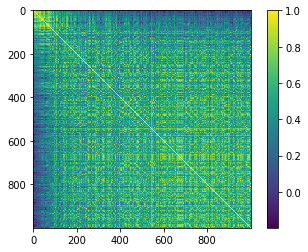

In [214]:
plt.imshow(Z)
plt.colorbar()
def top_sim(i):
    print("'{}' top words".format(top_sources[i][0]))
    for j in Z[:, i].argsort()[-20:][::-1]:
        print(top_targets[j][0])

In [215]:
sources = list(map(lambda x: x[0], top_sources))

In [236]:
top_sim(sources.index("music"))

'music' top words
music
art
film
writing
popular
works
rock
literature
style
famous
series
book
parts
history
science
arts
culture
television
work
computer


In [231]:
max_sim = Z[:, sources.index("music")].argsort()[-50:]
a, b = sample_dpp(Z[max_sim])
for x in a:
    print(top_targets[max_sim[x]][0])

well
game
records
historical
television
history
writing


In [218]:
?np.eye